In [2]:
import pypsa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import numpy_financial as npf
import networkx as nx
from openpyxl import Workbook

In [3]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])
dch_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCH_volume_mw.xlsx', parse_dates=['Timestamp'])
dcl_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCL_volume_mw.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_volume = dch_volume_data.set_index('Timestamp')['Volume (MW)']
dcl_volume = dcl_volume_data.set_index('Timestamp')['Volume (MW)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')
dch_volume = dch_volume.reindex(wind_data.index, method='nearest')
dcl_volume = dcl_volume.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Base values for parameters
base_capex_per_mw = 626310
base_opex_per_mw_per_year = 28728
base_efficiency_store = 0.92
base_efficiency_dispatch = 0.92
base_battery_lifetime = 15
base_discount_rate = 0.07
base_price_escalation_rate = 0.10
base_max_hours = 2
base_cfd_strike_price = 245.29

# Scenario definitions
scenarios = [
    {
        'capex_per_mw': base_capex_per_mw * 0.8,
        'opex_per_mw_per_year': base_opex_per_mw_per_year * 0.8,
        'efficiency_store': 0.99,
        'efficiency_dispatch': 0.99,
        'battery_lifetime': 25,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'cfd_strike_price': base_cfd_strike_price * 1.2,
        'market_price_factor': 1.2,
        'dch_prices_factor': 1.2,
        'dcl_prices_factor': 1.2
    },
    {
        'capex_per_mw': base_capex_per_mw * 0.864,
        'opex_per_mw_per_year': base_opex_per_mw_per_year * 0.853,
        'efficiency_store': 0.985,
        'efficiency_dispatch': 0.985,
        'battery_lifetime': 20,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'cfd_strike_price': base_cfd_strike_price * 1.1309,
        'market_price_factor': 1.1309,
        'dch_prices_factor': 1.1309,
        'dcl_prices_factor': 1.1309
    },
    {
        'capex_per_mw': base_capex_per_mw,
        'opex_per_mw_per_year': base_opex_per_mw_per_year,
        'efficiency_store': base_efficiency_store,
        'efficiency_dispatch': base_efficiency_dispatch,
        'battery_lifetime': base_battery_lifetime,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'cfd_strike_price': base_cfd_strike_price,
        'market_price_factor': 1.0,
        'dch_prices_factor': 1.0,
        'dcl_prices_factor': 1.0
    },
    {
        'capex_per_mw': base_capex_per_mw * 1.136,
        'opex_per_mw_per_year': base_opex_per_mw_per_year * 1.147,
        'efficiency_store': 0.845,
        'efficiency_dispatch': 0.845,
        'battery_lifetime': 10,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'cfd_strike_price': base_cfd_strike_price * 0.8691,
        'market_price_factor': 0.8691,
        'dch_prices_factor': 0.8691,
        'dcl_prices_factor': 0.8691
    },
    {
        'capex_per_mw': base_capex_per_mw * 1.2,
        'opex_per_mw_per_year': base_opex_per_mw_per_year * 1.2,
        'efficiency_store': 0.84,
        'efficiency_dispatch': 0.84,
        'battery_lifetime': 5,
        'discount_rate': base_discount_rate,
        'price_escalation_rate': base_price_escalation_rate,
        'max_hours': base_max_hours,
        'cfd_strike_price': base_cfd_strike_price * 0.8,
        'market_price_factor': 0.8,
        'dch_prices_factor': 0.8,
        'dcl_prices_factor': 0.8
    }
]

results = []

for i, scenario in enumerate(scenarios, 1):
    print(f"Running scenario {i}...")

    # Adjust prices based on the scenario factors
    adjusted_market_prices = market_prices * scenario['market_price_factor']
    adjusted_dch_prices = dch_prices * scenario['dch_prices_factor']
    adjusted_dcl_prices = dcl_prices * scenario['dcl_prices_factor']

    # Calculate round trip efficiency
    round_trip_efficiency = scenario['efficiency_store'] * scenario['efficiency_dispatch']

    # Initialize the network
    network = pypsa.Network()

    # Add time steps to the network
    network.set_snapshots(wind_data.index)

    # Add carriers
    network.add("Carrier", "electricity")

    # Add buses
    network.add("Bus", "wind_bus", carrier="electricity")
    network.add("Bus", "grid_bus", carrier="electricity")

    # Add components to the network
    network.add("Generator",
                "wind_turbine",
                bus="wind_bus",
                p_nom=84,  # Generator nominal power (MW)
                p_set=wind_generation_profile.values,  # Set power output directly
                marginal_cost=0,
                capital_cost=0)

    network.add("StorageUnit",
                "battery",
                bus="wind_bus",
                p_nom_extendable=True,  # Make p_nom extendable
                max_hours=scenario['max_hours'],  # Maximum storage time in hours
                marginal_cost=0.01,  # Storage marginal cost
                capital_cost=scenario['capex_per_mw'], # CAPEX from scenario
                cyclic_state_of_charge=True,
                state_of_charge_initial=0,
                efficiency_store=scenario['efficiency_store'],
                efficiency_dispatch=scenario['efficiency_dispatch'])

    network.add("Load",
                "grid_demand",
                bus="grid_bus",
                sign=-1,
                p_set=demand_profile.values)

    network.add("Generator",
                "Backup Generator",
                bus="grid_bus",
                p_nom_extendable=True,
                marginal_cost=adjusted_market_prices.values,
                capital_cost=1500000)

    network.add("Generator",
                "DCH Service",
                bus="grid_bus",
                p_nom_extendable=True,  # Make p_nom extendable
                marginal_cost=adjusted_dch_prices.values,
                capital_cost=1700000)

    network.add("Generator",
                "DCL Service",
                bus="grid_bus",
                p_nom_extendable=True,  # Make p_nom extendable
                marginal_cost=adjusted_dcl_prices.values,
                capital_cost=1600000)

    network.add("Link",
                "wind_to_grid",
                bus0="wind_bus",
                bus1="grid_bus",
                efficiency=0.95,
                p_nom=82)

    network.add("Link",
                "grid_to_wind",
                bus0="grid_bus",
                bus1="wind_bus",
                efficiency=0.95,
                p_nom=82)

    # Optimize the network
    network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

    # Extract optimization results
    battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
    battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

    # Extract flows using p_dispatch and p_store
    battery_dispatch = network.storage_units_t.p_dispatch["battery"]
    battery_store = network.storage_units_t.p_store["battery"]
    wind_generation = network.generators_t.p["wind_turbine"]
    backup_generation = network.generators_t.p["Backup Generator"]
    DCH_generation = network.generators_t.p["DCH Service"]
    DCL_generation = network.generators_t.p["DCL Service"]
    load_demand = network.loads_t.p["grid_demand"]
    soc = network.storage_units_t["state_of_charge"]["battery"]
    soc_percentage = soc / battery_capacity_mwh * 100

    # Calculate total energy
    total_battery_dispatch = battery_dispatch.sum()
    total_battery_store = battery_store.sum()

    # Calculate revenues
    cfd_strike_price = scenario['cfd_strike_price']

    # Calculate CFD Revenue (No Arbitrage Cost, as the wind and battery are on same bus)
    data = pd.DataFrame({
        'Timestamp': wind_data.index,
        'Market Price (£/MWh)': adjusted_market_prices,
        'DCH Price (£/MWh)': adjusted_dch_prices,
        'DCL Price (£/MWh)': adjusted_dcl_prices,
        'Battery Dispatch (MW)': battery_dispatch,
        'Battery Store (MW)': battery_store,
        'Wind Generation (MW)': wind_generation,
        'Backup Generation (MW)': backup_generation,
        'DCH Generation (MW)': DCH_generation,
        'DCL Generation (MW)': DCL_generation,
        'Load Demand (MW)': load_demand,
        'State of Charge (MWh)': soc,
        'State of Charge (%)': soc_percentage
    })

    data['CFD Revenue (£)'] = data['Wind Generation (MW)'] * cfd_strike_price
    data['Arbitrage Revenue (£)'] = data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)']
    data['DCL Revenue (£)'] = data['Battery Dispatch (MW)'] * data['DCL Price (£/MWh)']
    data['DCH Revenue (£)'] = data['Battery Store (MW)'] * data['DCH Price (£/MWh)']
    data['Battery Revenue (£)'] = data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)']
    data['Total Project Revenue (£)'] = data['CFD Revenue (£)'] + data['Battery Revenue (£)']

    # Calculate financial metrics
    annual_battery_revenue = data['Battery Revenue (£)'].sum()
    discount_rate = scenario['discount_rate']
    battery_lifetime = int(scenario['battery_lifetime'])  # Ensure battery_lifetime is an integer
    capex_per_mw = scenario['capex_per_mw']
    opex_per_mw_per_year = scenario['opex_per_mw_per_year']
    price_escalation_rate = scenario['price_escalation_rate']

    # Total CAPEX
    total_capex = battery_size_mw * capex_per_mw

    # Calculate annual battery revenues with escalation
    annual_battery_revenues = [(annual_battery_revenue * (1 + price_escalation_rate) ** year) for year in range(battery_lifetime)]
    annual_opex = [(opex_per_mw_per_year * battery_size_mw * (1 + price_escalation_rate) ** year) for year in range(battery_lifetime)]
    annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
    annual_cash_flows.insert(0, -total_capex)  # Initial investment in year 0

    # NPV Calculation
    npv = npf.npv(discount_rate, annual_cash_flows)

    # IRR Calculation
    irr = npf.irr(annual_cash_flows) * 100  # Convert to percentage

    # Total discounted OPEX
    total_opex = sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

    # Total discounted costs
    total_discounted_costs = total_capex + total_opex

    # Total energy dispatched over the lifetime (MWh)
    total_energy_dispatched = total_battery_dispatch * battery_lifetime

    # LCOS Calculation
    lcos = total_discounted_costs / total_energy_dispatched

    # Payback Period Calculation
    cumulative_cash_flow = 0
    payback_period = None
    for year, cash_flow in enumerate(annual_cash_flows):
        cumulative_cash_flow += cash_flow
        if cumulative_cash_flow >= 0 and payback_period is None:
            payback_period = year

    # Store results
    results.append({
        'Scenario': i,
        'Battery Size (MW)': battery_size_mw,
        'Battery Capacity (MWh)': battery_capacity_mwh,
        'Total Battery Dispatch (MWh)': total_battery_dispatch,
        'Total Battery Store (MWh)': total_battery_store,
        'Round Trip Efficiency': round_trip_efficiency,
        'NPV (£)': npv,
        'IRR (%)': irr,
        'LCOS (£/MWh)': lcos,
        'Payback Period (years)': payback_period,
        'Battery Lifetime (years)': battery_lifetime,
        'Discount Rate': discount_rate,
        'Price Escalation Rate': price_escalation_rate,
        'Max Hours': scenario['max_hours'],
        'CAPEX (£/MW)': capex_per_mw,
        'OPEX (£/MW/year)': opex_per_mw_per_year,
        'CFD Strike Price (£/MWh)': cfd_strike_price,
        'Market Price Factor': scenario['market_price_factor'],
        'DCH Prices Factor': scenario['dch_prices_factor'],
        'DCL Prices Factor': scenario['dcl_prices_factor'],
        'Total Battery Revenue (£)': annual_battery_revenue,
        'Total Project Revenue (£)': data['Total Project Revenue (£)'].sum()
    })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Save results to an Excel file
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Scenario_Analysis_Results.xlsx'
results_df.to_excel(output_path, index=False)
print(f"Scenario analysis results saved to {output_path}")


Running scenario 1...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 86.05it/s]
INFO:linopy.io: Writing time: 0.54s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-k37m1t8o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-k37m1t8o.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x5d3e0a48


INFO:gurobipy:Model fingerprint: 0x5d3e0a48


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.12s


INFO:gurobipy:Ordering time: 0.12s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.37598742e+11 -2.83423486e+10  8.58e+04 3.87e+01  4.57e+08     1s


INFO:gurobipy:   0   3.37598742e+11 -2.83423486e+10  8.58e+04 3.87e+01  4.57e+08     1s


   1   4.23388239e+11 -2.16756392e+12  2.01e+04 1.34e+03  8.31e+07     1s


INFO:gurobipy:   1   4.23388239e+11 -2.16756392e+12  2.01e+04 1.34e+03  8.31e+07     1s


   2   3.97206667e+11 -7.30539334e+11  1.72e+03 3.23e+02  1.81e+07     1s


INFO:gurobipy:   2   3.97206667e+11 -7.30539334e+11  1.72e+03 3.23e+02  1.81e+07     1s


   3   2.58679049e+11  3.93713109e+10  2.51e+02 7.36e+00  1.89e+06     1s


INFO:gurobipy:   3   2.58679049e+11  3.93713109e+10  2.51e+02 7.36e+00  1.89e+06     1s


   4   2.02206089e+11  5.90910894e+10  1.43e+02 4.17e+00  1.12e+06     1s


INFO:gurobipy:   4   2.02206089e+11  5.90910894e+10  1.43e+02 4.17e+00  1.12e+06     1s


   5   1.95639430e+11  9.42796109e+10  1.28e+02 1.27e+00  7.34e+05     1s


INFO:gurobipy:   5   1.95639430e+11  9.42796109e+10  1.28e+02 1.27e+00  7.34e+05     1s


   6   1.91780908e+11  9.92587023e+10  1.19e+02 1.11e+00  6.64e+05     1s


INFO:gurobipy:   6   1.91780908e+11  9.92587023e+10  1.19e+02 1.11e+00  6.64e+05     1s


   7   1.86417765e+11  1.17700935e+11  1.03e+02 5.95e-01  4.85e+05     1s


INFO:gurobipy:   7   1.86417765e+11  1.17700935e+11  1.03e+02 5.95e-01  4.85e+05     1s


   8   1.60504493e+11  1.45444216e+11  1.09e+01 5.01e-07  9.37e+04     1s


INFO:gurobipy:   8   1.60504493e+11  1.45444216e+11  1.09e+01 5.01e-07  9.37e+04     1s


   9   1.56317143e+11  1.51936192e+11  2.28e+00 2.82e-07  2.67e+04     1s


INFO:gurobipy:   9   1.56317143e+11  1.51936192e+11  2.28e+00 2.82e-07  2.67e+04     1s


  10   1.54520020e+11  1.53074916e+11  5.23e-01 1.27e-06  8.77e+03     1s


INFO:gurobipy:  10   1.54520020e+11  1.53074916e+11  5.23e-01 1.27e-06  8.77e+03     1s


  11   1.54107986e+11  1.53517149e+11  2.06e-01 8.73e-07  3.58e+03     1s


INFO:gurobipy:  11   1.54107986e+11  1.53517149e+11  2.06e-01 8.73e-07  3.58e+03     1s


  12   1.54071394e+11  1.53658590e+11  1.77e-01 5.86e-07  2.50e+03     1s


INFO:gurobipy:  12   1.54071394e+11  1.53658590e+11  1.77e-01 5.86e-07  2.50e+03     1s


  13   1.54030281e+11  1.53705202e+11  1.46e-01 5.25e-07  1.97e+03     1s


INFO:gurobipy:  13   1.54030281e+11  1.53705202e+11  1.46e-01 5.25e-07  1.97e+03     1s


  14   1.54018541e+11  1.53723239e+11  1.37e-01 3.94e-07  1.79e+03     1s


INFO:gurobipy:  14   1.54018541e+11  1.53723239e+11  1.37e-01 3.94e-07  1.79e+03     1s


  15   1.53950652e+11  1.53761565e+11  8.56e-02 4.05e-07  1.14e+03     1s


INFO:gurobipy:  15   1.53950652e+11  1.53761565e+11  8.56e-02 4.05e-07  1.14e+03     1s


  16   1.53932447e+11  1.53794233e+11  7.24e-02 3.13e-07  8.36e+02     1s


INFO:gurobipy:  16   1.53932447e+11  1.53794233e+11  7.24e-02 3.13e-07  8.36e+02     1s


  17   1.53906536e+11  1.53805291e+11  5.18e-02 2.37e-07  6.12e+02     1s


INFO:gurobipy:  17   1.53906536e+11  1.53805291e+11  5.18e-02 2.37e-07  6.12e+02     1s


  18   1.53892420e+11  1.53814419e+11  4.13e-02 2.18e-07  4.72e+02     1s


INFO:gurobipy:  18   1.53892420e+11  1.53814419e+11  4.13e-02 2.18e-07  4.72e+02     1s


  19   1.53890226e+11  1.53821491e+11  3.94e-02 9.57e-08  4.16e+02     1s


INFO:gurobipy:  19   1.53890226e+11  1.53821491e+11  3.94e-02 9.57e-08  4.16e+02     1s


  20   1.53890618e+11  1.53830809e+11  3.82e-02 9.51e-08  3.62e+02     1s


INFO:gurobipy:  20   1.53890618e+11  1.53830809e+11  3.82e-02 9.51e-08  3.62e+02     1s


  21   1.53881997e+11  1.53842723e+11  2.19e-02 1.27e-07  2.37e+02     1s


INFO:gurobipy:  21   1.53881997e+11  1.53842723e+11  2.19e-02 1.27e-07  2.37e+02     1s


  22   1.53874711e+11  1.53857644e+11  7.10e-03 7.47e-08  1.03e+02     1s


INFO:gurobipy:  22   1.53874711e+11  1.53857644e+11  7.10e-03 7.47e-08  1.03e+02     1s


  23   1.53872791e+11  1.53867667e+11  3.65e-03 4.31e-09  3.10e+01     1s


INFO:gurobipy:  23   1.53872791e+11  1.53867667e+11  3.65e-03 4.31e-09  3.10e+01     1s


  24   1.53871577e+11  1.53869373e+11  1.68e-03 7.68e-09  1.33e+01     2s


INFO:gurobipy:  24   1.53871577e+11  1.53869373e+11  1.68e-03 7.68e-09  1.33e+01     2s


  25   1.53870964e+11  1.53869884e+11  7.39e-04 4.54e-09  6.52e+00     2s


INFO:gurobipy:  25   1.53870964e+11  1.53869884e+11  7.39e-04 4.54e-09  6.52e+00     2s


  26   1.53870814e+11  1.53870130e+11  5.14e-04 6.75e-09  4.13e+00     2s


INFO:gurobipy:  26   1.53870814e+11  1.53870130e+11  5.14e-04 6.75e-09  4.13e+00     2s


  27   1.53870606e+11  1.53870274e+11  2.17e-04 1.98e-09  2.01e+00     2s


INFO:gurobipy:  27   1.53870606e+11  1.53870274e+11  2.17e-04 1.98e-09  2.01e+00     2s


  28   1.53870502e+11  1.53870387e+11  7.23e-05 2.68e-09  6.94e-01     2s


INFO:gurobipy:  28   1.53870502e+11  1.53870387e+11  7.23e-05 2.68e-09  6.94e-01     2s


  29   1.53870470e+11  1.53870414e+11  3.45e-05 1.16e-10  3.41e-01     2s


INFO:gurobipy:  29   1.53870470e+11  1.53870414e+11  3.45e-05 1.16e-10  3.41e-01     2s


  30   1.53870460e+11  1.53870425e+11  1.98e-05 5.24e-09  2.12e-01     2s


INFO:gurobipy:  30   1.53870460e+11  1.53870425e+11  1.98e-05 5.24e-09  2.12e-01     2s


  31   1.53870450e+11  1.53870435e+11  7.83e-06 1.59e-09  9.57e-02     2s


INFO:gurobipy:  31   1.53870450e+11  1.53870435e+11  7.83e-06 1.59e-09  9.57e-02     2s


  32   1.53870448e+11  1.53870439e+11  4.69e-06 9.31e-10  5.06e-02     2s


INFO:gurobipy:  32   1.53870448e+11  1.53870439e+11  4.69e-06 9.31e-10  5.06e-02     2s


  33   1.53870445e+11  1.53870442e+11  5.60e-06 1.98e-09  1.91e-02     2s


INFO:gurobipy:  33   1.53870445e+11  1.53870442e+11  5.60e-06 1.98e-09  1.91e-02     2s


  34   1.53870444e+11  1.53870443e+11  4.46e-06 4.07e-09  6.44e-03     2s


INFO:gurobipy:  34   1.53870444e+11  1.53870443e+11  4.46e-06 4.07e-09  6.44e-03     2s


  35   1.53870444e+11  1.53870443e+11  2.13e-06 2.79e-09  2.98e-03     2s


INFO:gurobipy:  35   1.53870444e+11  1.53870443e+11  2.13e-06 2.79e-09  2.98e-03     2s


  36   1.53870443e+11  1.53870443e+11  8.65e-07 3.53e-11  1.15e-03     2s


INFO:gurobipy:  36   1.53870443e+11  1.53870443e+11  8.65e-07 3.53e-11  1.15e-03     2s


  37   1.53870443e+11  1.53870443e+11  6.41e-07 1.51e-09  1.82e-04     2s


INFO:gurobipy:  37   1.53870443e+11  1.53870443e+11  6.41e-07 1.51e-09  1.82e-04     2s


  38   1.53870443e+11  1.53870443e+11  5.05e-08 7.80e-09  4.95e-05     2s


INFO:gurobipy:  38   1.53870443e+11  1.53870443e+11  5.05e-08 7.80e-09  4.95e-05     2s


  39   1.53870443e+11  1.53870443e+11  4.67e-08 1.98e-08  1.66e-05     2s


INFO:gurobipy:  39   1.53870443e+11  1.53870443e+11  4.67e-08 1.98e-08  1.66e-05     2s


  40   1.53870443e+11  1.53870443e+11  1.26e-08 3.31e-08  2.79e-07     2s


INFO:gurobipy:  40   1.53870443e+11  1.53870443e+11  1.26e-08 3.31e-08  2.79e-07     2s


  41   1.53870443e+11  1.53870443e+11  8.09e-09 5.47e-08  4.03e-10     2s


INFO:gurobipy:  41   1.53870443e+11  1.53870443e+11  8.09e-09 5.47e-08  4.03e-10     2s


INFO:gurobipy:


Barrier solved model in 41 iterations and 2.01 seconds (1.67 work units)


INFO:gurobipy:Barrier solved model in 41 iterations and 2.01 seconds (1.67 work units)


Optimal objective 1.53870443e+11


INFO:gurobipy:Optimal objective 1.53870443e+11


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   49234    1.5387044e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   49234    1.5387044e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 49234 iterations and 2.07 seconds (1.99 work units)


INFO:gurobipy:Solved in 49234 iterations and 2.07 seconds (1.99 work units)


Optimal objective  1.538704434e+11


INFO:gurobipy:Optimal objective  1.538704434e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.54e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 2...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 61.73it/s]
INFO:linopy.io: Writing time: 0.53s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-z2_m64a7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-z2_m64a7.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x5d50da31


INFO:gurobipy:Model fingerprint: 0x5d50da31


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.32220066e+11 -2.76563496e+10  8.59e+04 3.65e+01  4.47e+08     0s


INFO:gurobipy:   0   3.32220066e+11 -2.76563496e+10  8.59e+04 3.65e+01  4.47e+08     0s


   1   4.23692038e+11 -2.09979811e+12  2.06e+04 1.33e+03  8.26e+07     0s


INFO:gurobipy:   1   4.23692038e+11 -2.09979811e+12  2.06e+04 1.33e+03  8.26e+07     0s


   2   3.99244307e+11 -7.48563624e+11  2.15e+03 3.39e+02  1.93e+07     0s


INFO:gurobipy:   2   3.99244307e+11 -7.48563624e+11  2.15e+03 3.39e+02  1.93e+07     0s


   3   2.61460810e+11  3.71399995e+10  2.27e+02 8.70e+00  1.94e+06     0s


INFO:gurobipy:   3   2.61460810e+11  3.71399995e+10  2.27e+02 8.70e+00  1.94e+06     0s


   4   2.02109831e+11  5.90859532e+10  1.18e+02 4.79e+00  1.11e+06     0s


INFO:gurobipy:   4   2.02109831e+11  5.90859532e+10  1.18e+02 4.79e+00  1.11e+06     0s


   5   1.92742011e+11  9.63395414e+10  1.02e+02 1.27e+00  6.90e+05     0s


INFO:gurobipy:   5   1.92742011e+11  9.63395414e+10  1.02e+02 1.27e+00  6.90e+05     0s


   6   1.90221164e+11  1.03094112e+11  9.58e+01 1.09e+00  6.21e+05     0s


INFO:gurobipy:   6   1.90221164e+11  1.03094112e+11  9.58e+01 1.09e+00  6.21e+05     0s


   7   1.81346940e+11  1.28583765e+11  6.78e+01 3.04e-01  3.62e+05     1s


INFO:gurobipy:   7   1.81346940e+11  1.28583765e+11  6.78e+01 3.04e-01  3.62e+05     1s


   8   1.61124512e+11  1.41284811e+11  1.41e+01 7.45e-09  1.26e+05     1s


INFO:gurobipy:   8   1.61124512e+11  1.41284811e+11  1.41e+01 7.45e-09  1.26e+05     1s


   9   1.56352250e+11  1.50505791e+11  3.62e+00 1.59e-12  3.60e+04     1s


INFO:gurobipy:   9   1.56352250e+11  1.50505791e+11  3.62e+00 1.59e-12  3.60e+04     1s


  10   1.55056636e+11  1.52313478e+11  1.57e+00 1.14e-08  1.68e+04     1s


INFO:gurobipy:  10   1.55056636e+11  1.52313478e+11  1.57e+00 1.14e-08  1.68e+04     1s


  11   1.54147866e+11  1.53107230e+11  5.17e-01 1.53e-08  6.35e+03     1s


INFO:gurobipy:  11   1.54147866e+11  1.53107230e+11  5.17e-01 1.53e-08  6.35e+03     1s


  12   1.53975143e+11  1.53445086e+11  3.39e-01 4.62e-08  3.22e+03     1s


INFO:gurobipy:  12   1.53975143e+11  1.53445086e+11  3.39e-01 4.62e-08  3.22e+03     1s


  13   1.53832105e+11  1.53567373e+11  1.97e-01 2.27e-07  1.61e+03     1s


INFO:gurobipy:  13   1.53832105e+11  1.53567373e+11  1.97e-01 2.27e-07  1.61e+03     1s


  14   1.53809902e+11  1.53591282e+11  1.75e-01 3.66e-07  1.32e+03     1s


INFO:gurobipy:  14   1.53809902e+11  1.53591282e+11  1.75e-01 3.66e-07  1.32e+03     1s


  15   1.53762346e+11  1.53599490e+11  1.28e-01 3.71e-07  9.87e+02     1s


INFO:gurobipy:  15   1.53762346e+11  1.53599490e+11  1.28e-01 3.71e-07  9.87e+02     1s


  16   1.53732717e+11  1.53608044e+11  9.85e-02 2.88e-07  7.55e+02     1s


INFO:gurobipy:  16   1.53732717e+11  1.53608044e+11  9.85e-02 2.88e-07  7.55e+02     1s


  17   1.53707495e+11  1.53616989e+11  7.31e-02 2.53e-07  5.48e+02     1s


INFO:gurobipy:  17   1.53707495e+11  1.53616989e+11  7.31e-02 2.53e-07  5.48e+02     1s


  18   1.53695446e+11  1.53621865e+11  6.20e-02 2.57e-07  4.45e+02     1s


INFO:gurobipy:  18   1.53695446e+11  1.53621865e+11  6.20e-02 2.57e-07  4.45e+02     1s


  19   1.53695106e+11  1.53624292e+11  6.16e-02 2.36e-07  4.28e+02     1s


INFO:gurobipy:  19   1.53695106e+11  1.53624292e+11  6.16e-02 2.36e-07  4.28e+02     1s


  20   1.53680692e+11  1.53656197e+11  2.40e-02 2.25e-07  1.48e+02     1s


INFO:gurobipy:  20   1.53680692e+11  1.53656197e+11  2.40e-02 2.25e-07  1.48e+02     1s


  21   1.53674626e+11  1.53665214e+11  1.03e-02 9.12e-08  5.69e+01     1s


INFO:gurobipy:  21   1.53674626e+11  1.53665214e+11  1.03e-02 9.12e-08  5.69e+01     1s


  22   1.53672056e+11  1.53667619e+11  4.80e-03 4.44e-08  2.68e+01     1s


INFO:gurobipy:  22   1.53672056e+11  1.53667619e+11  4.80e-03 4.44e-08  2.68e+01     1s


  23   1.53671037e+11  1.53668692e+11  2.70e-03 2.15e-08  1.42e+01     1s


INFO:gurobipy:  23   1.53671037e+11  1.53668692e+11  2.70e-03 2.15e-08  1.42e+01     1s


  24   1.53670266e+11  1.53669291e+11  1.16e-03 1.35e-08  5.90e+00     1s


INFO:gurobipy:  24   1.53670266e+11  1.53669291e+11  1.16e-03 1.35e-08  5.90e+00     1s


  25   1.53669785e+11  1.53669526e+11  2.50e-04 2.10e-09  1.57e+00     1s


INFO:gurobipy:  25   1.53669785e+11  1.53669526e+11  2.50e-04 2.10e-09  1.57e+00     1s


  26   1.53669699e+11  1.53669579e+11  1.07e-04 2.44e-09  7.25e-01     1s


INFO:gurobipy:  26   1.53669699e+11  1.53669579e+11  1.07e-04 2.44e-09  7.25e-01     1s


  27   1.53669664e+11  1.53669606e+11  5.17e-05 2.79e-09  3.50e-01     1s


INFO:gurobipy:  27   1.53669664e+11  1.53669606e+11  5.17e-05 2.79e-09  3.50e-01     1s


  28   1.53669646e+11  1.53669617e+11  2.36e-05 1.05e-09  1.76e-01     1s


INFO:gurobipy:  28   1.53669646e+11  1.53669617e+11  2.36e-05 1.05e-09  1.76e-01     1s


  29   1.53669636e+11  1.53669626e+11  3.38e-05 1.75e-09  6.22e-02     1s


INFO:gurobipy:  29   1.53669636e+11  1.53669626e+11  3.38e-05 1.75e-09  6.22e-02     1s


  30   1.53669632e+11  1.53669629e+11  4.38e-05 1.14e-09  1.35e-02     1s


INFO:gurobipy:  30   1.53669632e+11  1.53669629e+11  4.38e-05 1.14e-09  1.35e-02     1s


  31   1.53669631e+11  1.53669630e+11  1.95e-05 3.49e-09  3.31e-03     1s


INFO:gurobipy:  31   1.53669631e+11  1.53669630e+11  1.95e-05 3.49e-09  3.31e-03     1s


  32   1.53669631e+11  1.53669631e+11  1.08e-05 2.56e-09  1.37e-03     1s


INFO:gurobipy:  32   1.53669631e+11  1.53669631e+11  1.08e-05 2.56e-09  1.37e-03     1s


  33   1.53669631e+11  1.53669631e+11  3.40e-06 2.10e-09  3.94e-04     1s


INFO:gurobipy:  33   1.53669631e+11  1.53669631e+11  3.40e-06 2.10e-09  3.94e-04     1s


  34   1.53669631e+11  1.53669631e+11  2.20e-07 5.60e-08  5.95e-05     1s


INFO:gurobipy:  34   1.53669631e+11  1.53669631e+11  2.20e-07 5.60e-08  5.95e-05     1s


  35   1.53669631e+11  1.53669631e+11  3.54e-08 7.12e-08  6.89e-06     1s


INFO:gurobipy:  35   1.53669631e+11  1.53669631e+11  3.54e-08 7.12e-08  6.89e-06     1s


  36   1.53669631e+11  1.53669631e+11  5.06e-09 6.57e-08  2.28e-07     1s


INFO:gurobipy:  36   1.53669631e+11  1.53669631e+11  5.06e-09 6.57e-08  2.28e-07     1s


  37   1.53669631e+11  1.53669631e+11  3.55e-09 4.97e-08  2.54e-10     1s


INFO:gurobipy:  37   1.53669631e+11  1.53669631e+11  3.55e-09 4.97e-08  2.54e-10     1s


INFO:gurobipy:


Barrier solved model in 37 iterations and 1.32 seconds (1.50 work units)


INFO:gurobipy:Barrier solved model in 37 iterations and 1.32 seconds (1.50 work units)


Optimal objective 1.53669631e+11


INFO:gurobipy:Optimal objective 1.53669631e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2437 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2437 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4453 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4453 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9676015e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9676015e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    6893    1.5366963e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    6893    1.5366963e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 6893 iterations and 1.46 seconds (1.65 work units)


INFO:gurobipy:Solved in 6893 iterations and 1.46 seconds (1.65 work units)


Optimal objective  1.536696307e+11


INFO:gurobipy:Optimal objective  1.536696307e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.54e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 3...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 97.09it/s]
INFO:linopy.io: Writing time: 0.5s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-pa797tmh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-pa797tmh.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     1s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     1s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     1s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     1s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     1s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     1s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     1s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     1s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     1s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.23 seconds (1.44 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.23 seconds (1.44 work units)


Optimal objective 1.53248476e+11


INFO:gurobipy:Optimal objective 1.53248476e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2803 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2803 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.30 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.30 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 4...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 98.87it/s]
INFO:linopy.io: Writing time: 0.49s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-gertaa2r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-gertaa2r.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x19a64d4d


INFO:gurobipy:Model fingerprint: 0x19a64d4d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [9e-03, 2e+06]


INFO:gurobipy:  Objective range  [9e-03, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.48287840e+11 -1.83816140e+10  1.28e+05 2.80e+01  4.47e+08     0s


INFO:gurobipy:   0   3.48287840e+11 -1.83816140e+10  1.28e+05 2.80e+01  4.47e+08     0s


   1   4.74737910e+11 -1.43724321e+12  3.10e+04 1.05e+03  8.15e+07     0s


INFO:gurobipy:   1   4.74737910e+11 -1.43724321e+12  3.10e+04 1.05e+03  8.15e+07     0s


   2   3.97405630e+11 -3.28745797e+11  2.13e+03 4.10e+01  8.01e+06     0s


INFO:gurobipy:   2   3.97405630e+11 -3.28745797e+11  2.13e+03 4.10e+01  8.01e+06     0s


   3   2.18141293e+11  6.56603220e+10  5.63e+02 1.02e+00  1.53e+06     0s


INFO:gurobipy:   3   2.18141293e+11  6.56603220e+10  5.63e+02 1.02e+00  1.53e+06     0s


   4   1.99099718e+11  9.30041893e+10  4.53e+02 2.68e-09  1.02e+06     0s


INFO:gurobipy:   4   1.99099718e+11  9.30041893e+10  4.53e+02 2.68e-09  1.02e+06     0s


   5   1.89303193e+11  9.72640441e+10  3.89e+02 4.77e-09  8.71e+05     0s


INFO:gurobipy:   5   1.89303193e+11  9.72640441e+10  3.89e+02 4.77e-09  8.71e+05     0s


   6   1.87603915e+11  1.02547642e+11  3.82e+02 6.40e-09  8.12e+05     0s


INFO:gurobipy:   6   1.87603915e+11  1.02547642e+11  3.82e+02 6.40e-09  8.12e+05     0s


   7   1.82357338e+11  1.19432511e+11  3.15e+02 8.60e-08  6.01e+05     0s


INFO:gurobipy:   7   1.82357338e+11  1.19432511e+11  3.15e+02 8.60e-08  6.01e+05     0s


   8   1.61667002e+11  1.38993683e+11  8.37e+01 1.83e-07  1.78e+05     1s


INFO:gurobipy:   8   1.61667002e+11  1.38993683e+11  8.37e+01 1.83e-07  1.78e+05     1s


   9   1.57427384e+11  1.45449013e+11  4.27e+01 1.90e-07  8.52e+04     1s


INFO:gurobipy:   9   1.57427384e+11  1.45449013e+11  4.27e+01 1.90e-07  8.52e+04     1s


  10   1.55560874e+11  1.48186815e+11  2.52e+01 2.91e-07  4.97e+04     1s


INFO:gurobipy:  10   1.55560874e+11  1.48186815e+11  2.52e+01 2.91e-07  4.97e+04     1s


  11   1.54494850e+11  1.51223688e+11  1.56e+01 9.09e-07  2.10e+04     1s


INFO:gurobipy:  11   1.54494850e+11  1.51223688e+11  1.56e+01 9.09e-07  2.10e+04     1s


  12   1.53641432e+11  1.51999324e+11  8.31e+00 9.09e-07  1.03e+04     1s


INFO:gurobipy:  12   1.53641432e+11  1.51999324e+11  8.31e+00 9.09e-07  1.03e+04     1s


  13   1.53324207e+11  1.52159640e+11  5.67e+00 9.01e-07  7.23e+03     1s


INFO:gurobipy:  13   1.53324207e+11  1.52159640e+11  5.67e+00 9.01e-07  7.23e+03     1s


INFO:gurobipy:


Barrier performed 13 iterations in 0.68 seconds (0.68 work units)


INFO:gurobipy:Barrier performed 13 iterations in 0.68 seconds (0.68 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   44163    1.5262409e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   44163    1.5262409e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 44163 iterations and 0.72 seconds (0.84 work units)


INFO:gurobipy:Solved in 44163 iterations and 0.72 seconds (0.84 work units)


Optimal objective  1.526240852e+11


INFO:gurobipy:Optimal objective  1.526240852e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running scenario 5...


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 96.69it/s]
INFO:linopy.io: Writing time: 0.68s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-gv91ypx7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-gv91ypx7.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x76863201


INFO:gurobipy:Model fingerprint: 0x76863201


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-01, 2e+00]


INFO:gurobipy:  Matrix range     [8e-01, 2e+00]


  Objective range  [8e-03, 2e+06]


INFO:gurobipy:  Objective range  [8e-03, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.45049820e+11 -1.77748912e+10  1.30e+05 2.58e+01  4.36e+08     0s


INFO:gurobipy:   0   3.45049820e+11 -1.77748912e+10  1.30e+05 2.58e+01  4.36e+08     0s


   1   4.77842753e+11 -1.38920895e+12  3.15e+04 1.04e+03  8.05e+07     0s


INFO:gurobipy:   1   4.77842753e+11 -1.38920895e+12  3.15e+04 1.04e+03  8.05e+07     0s


   2   3.99612631e+11 -3.23281020e+11  2.21e+03 3.88e+01  7.96e+06     0s


INFO:gurobipy:   2   3.99612631e+11 -3.23281020e+11  2.21e+03 3.88e+01  7.96e+06     0s


   3   2.14905993e+11  6.61909097e+10  5.65e+02 9.07e-01  1.49e+06     0s


INFO:gurobipy:   3   2.14905993e+11  6.61909097e+10  5.65e+02 9.07e-01  1.49e+06     0s


   4   1.98847040e+11  9.51642151e+10  4.69e+02 1.42e-08  1.00e+06     0s


INFO:gurobipy:   4   1.98847040e+11  9.51642151e+10  4.69e+02 1.42e-08  1.00e+06     0s


   5   1.88315703e+11  9.76282177e+10  3.97e+02 1.30e-08  8.59e+05     0s


INFO:gurobipy:   5   1.88315703e+11  9.76282177e+10  3.97e+02 1.30e-08  8.59e+05     0s


   6   1.87097786e+11  1.12440021e+11  3.85e+02 7.22e-09  7.23e+05     0s


INFO:gurobipy:   6   1.87097786e+11  1.12440021e+11  3.85e+02 7.22e-09  7.23e+05     0s


   7   1.72184261e+11  1.34146141e+11  2.20e+02 1.07e-08  3.51e+05     1s


INFO:gurobipy:   7   1.72184261e+11  1.34146141e+11  2.20e+02 1.07e-08  3.51e+05     1s


   8   1.58977785e+11  1.44207038e+11  6.70e+01 2.75e-05  1.13e+05     1s


INFO:gurobipy:   8   1.58977785e+11  1.44207038e+11  6.70e+01 2.75e-05  1.13e+05     1s


   9   1.55827857e+11  1.49162366e+11  3.50e+01 3.02e-05  4.59e+04     1s


INFO:gurobipy:   9   1.55827857e+11  1.49162366e+11  3.50e+01 3.02e-05  4.59e+04     1s


  10   1.54017617e+11  1.50972835e+11  1.75e+01 3.02e-07  1.96e+04     1s


INFO:gurobipy:  10   1.54017617e+11  1.50972835e+11  1.75e+01 3.02e-07  1.96e+04     1s


  11   1.53158540e+11  1.51403158e+11  9.57e+00 4.38e-06  1.11e+04     1s


INFO:gurobipy:  11   1.53158540e+11  1.51403158e+11  9.57e+00 4.38e-06  1.11e+04     1s


  12   1.52831472e+11  1.51562712e+11  6.59e+00 5.28e-06  7.92e+03     1s


INFO:gurobipy:  12   1.52831472e+11  1.51562712e+11  6.59e+00 5.28e-06  7.92e+03     1s


  13   1.52605926e+11  1.51681072e+11  4.59e+00 5.42e-06  5.73e+03     1s


INFO:gurobipy:  13   1.52605926e+11  1.51681072e+11  4.59e+00 5.42e-06  5.73e+03     1s


INFO:gurobipy:


Barrier performed 13 iterations in 0.73 seconds (0.68 work units)


INFO:gurobipy:Barrier performed 13 iterations in 0.73 seconds (0.68 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   44421    1.5208623e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   44421    1.5208623e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 44421 iterations and 0.79 seconds (0.85 work units)


INFO:gurobipy:Solved in 44421 iterations and 0.79 seconds (0.85 work units)


Optimal objective  1.520862324e+11


INFO:gurobipy:Optimal objective  1.520862324e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.52e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


   Scenario  Battery Size (MW)  Battery Capacity (MWh)  \
0         1             79.998                 159.996   
1         2             79.998                 159.996   
2         3             79.998                 159.996   
3         4             79.998                 159.996   
4         5             79.998                 159.996   

   Total Battery Dispatch (MWh)  Total Battery Store (MWh)  \
0                  99778.726349              101804.638658   
1                  96653.100867               99619.264467   
2                  81880.021381               96739.155697   
3                  63543.714433               88993.682900   
4                  63096.645925               89422.684135   

   Round Trip Efficiency       NPV (£)    IRR (%)  LCOS (£/MWh)  \
0               0.980100  8.558491e+08  77.305581     40.545746   
1               0.970225  5.680118e+08  67.350509     47.358876   
2               0.846400  2.510644e+08  44.494923     72.855494   
3         

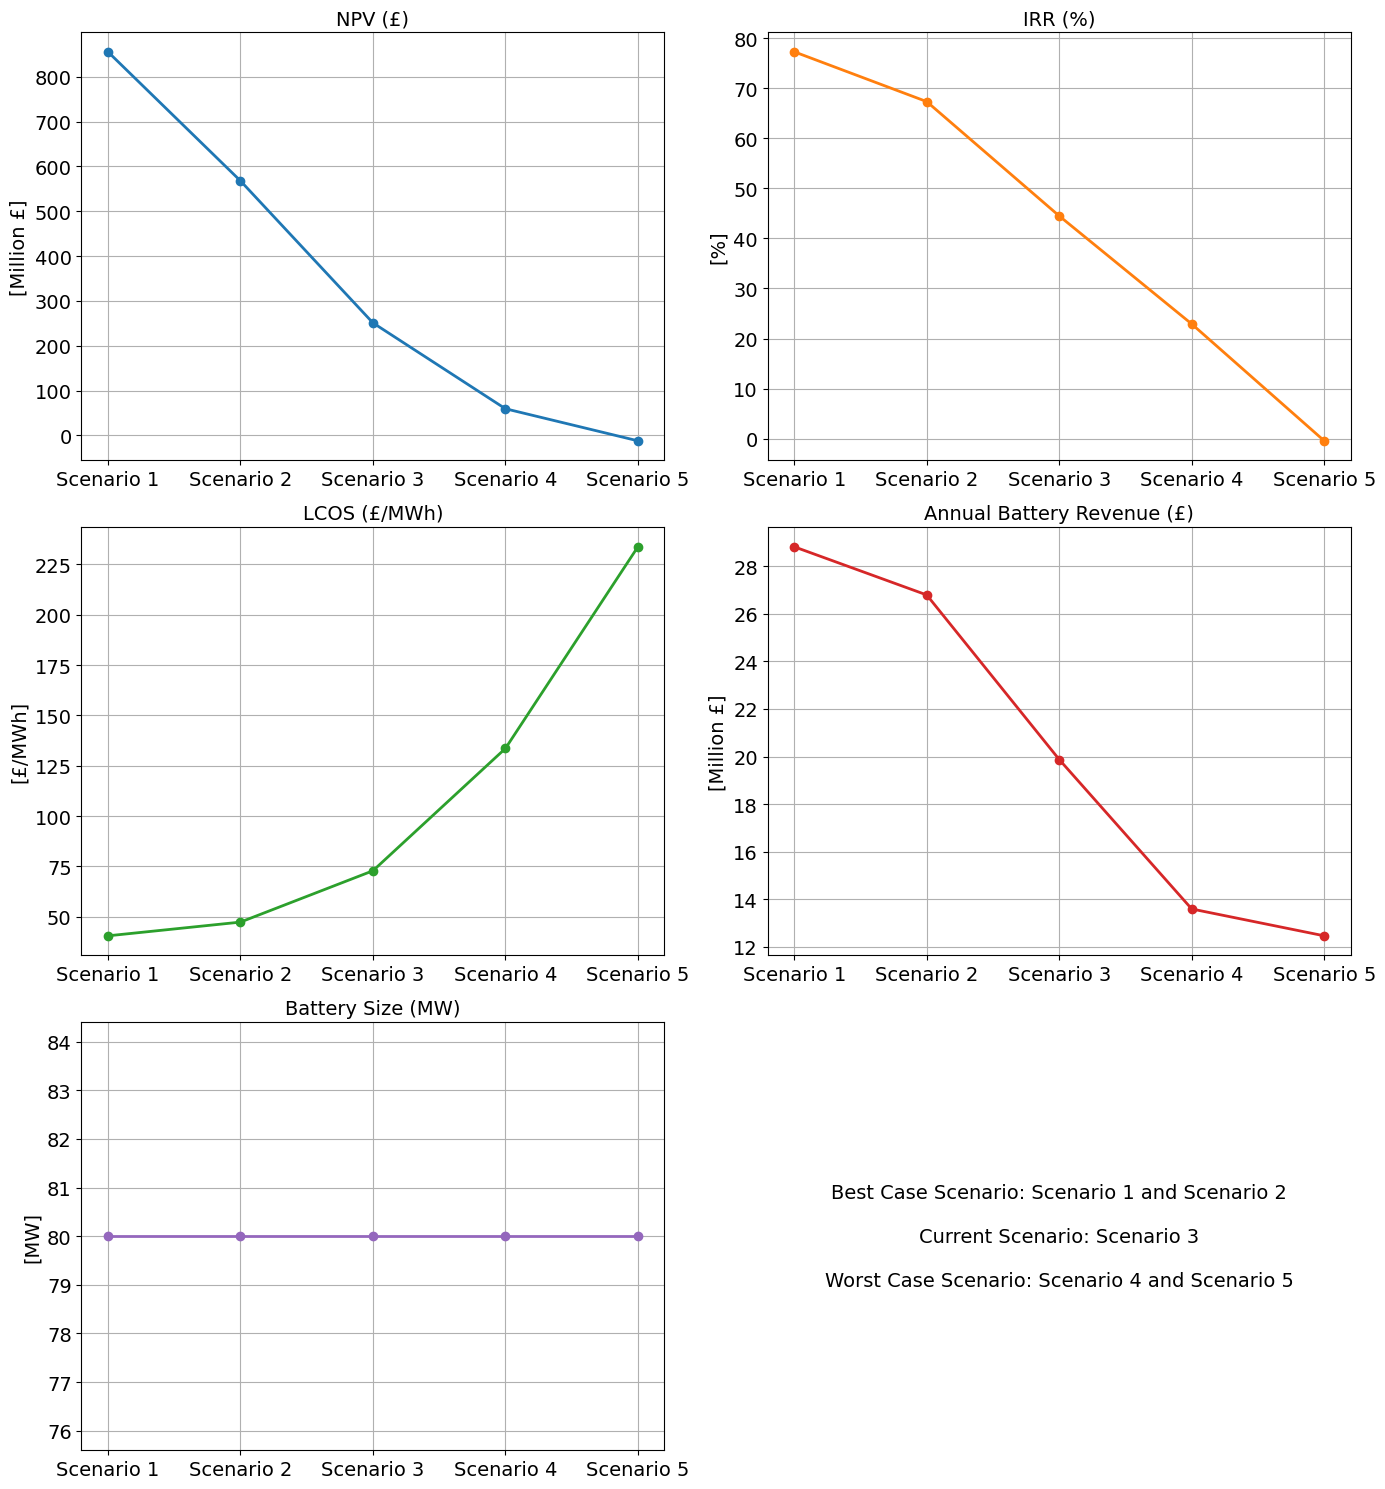

In [4]:
# Load the results from the Excel file
results_df = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Scenario_Analysis_Results.xlsx')

# Scenario labels
scenario_labels = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4', 'Scenario 5']

# Plotting parameters
font_size = 14
line_width = 2
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Using professional colors from matplotlib

# Formatter function for y-axis in millions without decimal points
def millions(x, pos):
    'The two args are the value and tick position'
    return f'{int(x * 1e-6)}'

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# NPV plot
axes[0, 0].plot(results_df['Scenario'], results_df['NPV (£)'], marker='o', linestyle='-', linewidth=line_width, color=line_colors[0])
axes[0, 0].set_title('NPV (£)', fontsize=font_size)
axes[0, 0].set_ylabel('[Million £]', fontsize=font_size)
axes[0, 0].set_yticks(range(0, 800000001, 100000000))
axes[0, 0].set_xticks(results_df['Scenario'])
axes[0, 0].set_xticklabels(scenario_labels, fontsize=font_size)
axes[0, 0].tick_params(axis='y', labelsize=font_size)
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(millions))
axes[0, 0].grid(True)

# IRR plot
axes[0, 1].plot(results_df['Scenario'], results_df['IRR (%)'], marker='o', linestyle='-', linewidth=line_width, color=line_colors[1])
axes[0, 1].set_title('IRR (%)', fontsize=font_size)
axes[0, 1].set_ylabel('[%]', fontsize=font_size)
axes[0, 1].set_xticks(results_df['Scenario'])
axes[0, 1].set_xticklabels(scenario_labels, fontsize=font_size)
axes[0, 1].tick_params(axis='y', labelsize=font_size)
axes[0, 1].grid(True)

# LCOS plot
axes[1, 0].plot(results_df['Scenario'], results_df['LCOS (£/MWh)'], marker='o', linestyle='-', linewidth=line_width, color=line_colors[2])
axes[1, 0].set_title('LCOS (£/MWh)', fontsize=font_size)
axes[1, 0].set_ylabel('[£/MWh]', fontsize=font_size)
axes[1, 0].set_xticks(results_df['Scenario'])
axes[1, 0].set_xticklabels(scenario_labels, fontsize=font_size)
axes[1, 0].tick_params(axis='y', labelsize=font_size)
axes[1, 0].grid(True)

# Battery Revenue plot
axes[1, 1].plot(results_df['Scenario'], results_df['Total Battery Revenue (£)'], marker='o', linestyle='-', linewidth=line_width, color=line_colors[3])
axes[1, 1].set_title('Annual Battery Revenue (£)', fontsize=font_size)
axes[1, 1].set_ylabel('[Million £]', fontsize=font_size)
axes[1, 1].set_xticks(results_df['Scenario'])
axes[1, 1].set_xticklabels(scenario_labels, fontsize=font_size)
axes[1, 1].tick_params(axis='y', labelsize=font_size)
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(millions))
axes[1, 1].grid(True)

# Battery Size plot (middle of the third row)
axes[2, 0].plot(results_df['Scenario'], results_df['Battery Size (MW)'], marker='o', linestyle='-', linewidth=line_width, color=line_colors[4])
axes[2, 0].set_title('Battery Size (MW)', fontsize=font_size)
axes[2, 0].set_ylabel('[MW]', fontsize=font_size)
axes[2, 0].set_xticks(results_df['Scenario'])
axes[2, 0].set_xticklabels(scenario_labels, fontsize=font_size)
axes[2, 0].tick_params(axis='y', labelsize=font_size)
axes[2, 0].grid(True)

# Remove the empty subplot (bottom-right) and add text there
axes[2, 1].axis('off')
axes[2, 1].text(0.5, 0.5, 'Best Case Scenario: Scenario 1 and Scenario 2\n\nCurrent Scenario: Scenario 3\n\nWorst Case Scenario: Scenario 4 and Scenario 5',
               ha='center', va='center', fontsize=font_size)

# Adjust layout
plt.tight_layout()

# Save plot in high quality
fig.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Sensitivity/Scenario_Analysis_Results.png', dpi=300)

# Show plot
plt.show()
